# Mapping and Analysis of Toronto Schools

## Project Overview
This project presents a comprehensive spatial and categorical analysis of schools across the City of Toronto. Using Python’s data science and geospatial libraries, the notebook explores school types, governance structures, education levels, and geographic distribution to uncover patterns relevant to urban planning and educational accessibility.

## Objectives
- Clean and preprocess raw school data
- Classify institutions by education level and board affiliation
- Analyze geographic distribution across Toronto districts
- Visualize school density and governance patterns
- Build interactive maps for spatial storytelling

## Data Exploration

The analysis begins by importing core Python libraries and loading the dataset `school_locations.csv`, which includes attributes such as school name, type, education level, board affiliation, and geolocation data.

Initial exploration includes:
- Overview of dataset structure and column types
- Record count and completeness
- Identification of missing values (absolute and percentage)

This step establishes a foundation for targeted cleaning and feature engineering.

In [1]:
# Import necessary libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
import folium
from folium.plugins import MarkerCluster, HeatMap
import ast

# Load dataset
df = pd.read_csv('data/school_locations.csv')
df.head()

,_id,OBJECTID,GEO_ID,NAME,SCHOOL_LEVEL,SCHOOL_TYPE,BOARD_NAME,SOURCE_ADDRESS,SCHOOL_TYPE_DESC,ADDRESS_POINT_ID,...,CITY,PLACE_NAME,GENERAL_USE_CODE,CENTRELINE_ID,LO_NUM,LO_NUM_SUF,HI_NUM,HI_NUM_SUF,LINEAR_NAME_ID,geometry
0,1,1,524780,A R S ARMENIAN PRIVATE SCHOOL,NaN,PR,NaN,50 HALLCROWN PL,Private,524780,...,NY,NaN,115001,438652,50,NaN,NaN,NaN,5778,"{""coordinates"": [[-79.323156147744, 43.7700530..."
1,2,2,517961,A Y JACKSON SECONDARY SCHOOL,NaN,EP,Toronto District School Board,50 FRANCINE DR,English Public,517961,...,NY,A. Y. Jackson Secondary School,115001,436260,50,NaN,NaN,NaN,5639,"{""coordinates"": [[-79.3665552934095, 43.805261..."
2,3,3,8594190,ABACUS MONTESSORI,NaN,PR,NaN,2723 ST CLAIR AVE E,Private,8594190,...,EY,Church Of St Columba and All,115001,8594192,2723,NaN,NaN,NaN,339,"{""coordinates"": [[-79.31007931829, 43.70574354..."
3,4,4,9602784,ABU HURAIRA ISLAMIC CENTRE AND ACADEMY,NaN,PR,NaN,270 YORKLAND BLVD,Private,9602784,...,NY,NaN,115001,30121150,270,NaN,NaN,NaN,7150,"{""coordinates"": [[-79.3345356762113, 43.772824..."
4,5,5,996700,ACACIA INTERNATIONAL HIGH SCHOOL,NaN,PR,NaN,235 DIXON RD,Private,996700,...,ET,NaN,115001,908498,235,NaN,NaN,NaN,1470,"{""coordinates"": [[-79.5439123761529, 43.696679..."


In [2]:
# Dataset overview
print("Data Shape:", df.shape)
print("\nDataset Info:\n")
df.info()

# Missing value analysis
missing_values = df.isnull().sum()
missing_pct = (missing_values / len(df)) * 100
print("\nMissing Values:\n", missing_values)
print("\nMissing Percentage (%):\n", round(missing_pct, 2))

Data Shape: (1171, 25)

Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1171 entries, 0 to 1170
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   _id               1171 non-null   int64  
 1   OBJECTID          1171 non-null   int64  
 2   GEO_ID            1171 non-null   int64  
 3   NAME              1171 non-null   object 
 4   SCHOOL_LEVEL      0 non-null      float64
 5   SCHOOL_TYPE       1128 non-null   object 
 6   BOARD_NAME        814 non-null    object 
 7   SOURCE_ADDRESS    1171 non-null   object 
 8   SCHOOL_TYPE_DESC  1128 non-null   object 
 9   ADDRESS_POINT_ID  1171 non-null   int64  
 10  ADDRESS_NUMBER    1171 non-null   object 
 11  LINEAR_NAME_FULL  1171 non-null   object 
 12  ADDRESS_FULL      1171 non-null   object 
 13  POSTAL_CODE       1157 non-null   object 
 14  MUNICIPALITY      1171 non-null   object 
 15  CITY              1171 non-null   object 
 16  PLA

## Data Cleaning & Feature Engineering

Schools are classified by level (e.g., elementary, middle, high, post-secondary) and board type. Duplicate entries are removed, and missing values are addressed to ensure consistency and reliability.

In [3]:
# Detect school level using keywords from school names
def detect_school_level(name):
    name = str(name).upper()
    
    if 'MIDDLE SCHOOL' in name or 'MDL SCHOOL' in name or 'JUNIOR HIGH SCHOOL' in name:
        return 'Middle'
    elif 'SENIOR PUBLIC SCHOOL' in name or 'SR PUBLIC SCHOOL' in name or 'INTERMEDIATE SCHOOL' in name:
        return 'Middle'
    elif 'ELEMENTARY' in name or 'MONTESSORI' in name or 'JR' in name or 'ACADEMY' in name or 'PUBLIC SCHOOL' in name:
        return 'Elementary'
    elif 'ELEMENTAIRE' in name or 'ACADEMIE' in name or 'COMMUNITY SCHOOL' in name or 'JR SCHOOL' in name:
        return 'Elementary'
    elif 'SECONDARY' in name or 'HIGH SCHOOL' in name or 'ALTERNATIVE' in name:
        return 'High'
    elif 'SECONDAIRE' in name or 'COLLEGIATE' in name or 'TECHNICAL' in name:
        return 'High'
    elif 'COLLEGE' in name or 'UNIVERSITY' in name or 'U OF T' in name or 'YORK U' in name or 'TMU' in name:
        return 'Post-secondary'
    else:
        return 'Others'

df['SCHOOL_LEVEL'] = df['SCHOOL_LEVEL'].fillna(df['NAME'].apply(detect_school_level))
df.head(10)

# Fill missing board names based on school type
def detect_board_name(school_type):
    if school_type == 'PR':
        return 'Private'

df['BOARD_NAME'] = df['BOARD_NAME'].fillna(df['SCHOOL_TYPE'].apply(detect_board_name))

# Checking the result
df.head()

,_id,OBJECTID,GEO_ID,NAME,SCHOOL_LEVEL,SCHOOL_TYPE,BOARD_NAME,SOURCE_ADDRESS,SCHOOL_TYPE_DESC,ADDRESS_POINT_ID,...,CITY,PLACE_NAME,GENERAL_USE_CODE,CENTRELINE_ID,LO_NUM,LO_NUM_SUF,HI_NUM,HI_NUM_SUF,LINEAR_NAME_ID,geometry
0,1,1,524780,A R S ARMENIAN PRIVATE SCHOOL,Others,PR,Private,50 HALLCROWN PL,Private,524780,...,NY,NaN,115001,438652,50,NaN,NaN,NaN,5778,"{""coordinates"": [[-79.323156147744, 43.7700530..."
1,2,2,517961,A Y JACKSON SECONDARY SCHOOL,High,EP,Toronto District School Board,50 FRANCINE DR,English Public,517961,...,NY,A. Y. Jackson Secondary School,115001,436260,50,NaN,NaN,NaN,5639,"{""coordinates"": [[-79.3665552934095, 43.805261..."
2,3,3,8594190,ABACUS MONTESSORI,Elementary,PR,Private,2723 ST CLAIR AVE E,Private,8594190,...,EY,Church Of St Columba and All,115001,8594192,2723,NaN,NaN,NaN,339,"{""coordinates"": [[-79.31007931829, 43.70574354..."
3,4,4,9602784,ABU HURAIRA ISLAMIC CENTRE AND ACADEMY,Elementary,PR,Private,270 YORKLAND BLVD,Private,9602784,...,NY,NaN,115001,30121150,270,NaN,NaN,NaN,7150,"{""coordinates"": [[-79.3345356762113, 43.772824..."
4,5,5,996700,ACACIA INTERNATIONAL HIGH SCHOOL,High,PR,Private,235 DIXON RD,Private,996700,...,ET,NaN,115001,908498,235,NaN,NaN,NaN,1470,"{""coordinates"": [[-79.5439123761529, 43.696679..."


In [4]:
# Remove duplicated schools by name and geographic ID
df_cleaned = df.drop_duplicates(subset=['NAME'])
df_cleaned = df_cleaned.drop_duplicates(subset=['GEO_ID'])

# Drop columns with >95% missing values
missing_ratio = df_cleaned.isnull().mean()
cols_to_drop = missing_ratio[missing_ratio > 0.95].index
df_cleaned = df_cleaned.drop(columns=cols_to_drop)

# Fill missing categorical fields with 'Unknown' — these values were either not provided or failed to load during data collection
cols_to_fill = ['SCHOOL_TYPE', 'BOARD_NAME', 'SCHOOL_TYPE_DESC', 'POSTAL_CODE', 'PLACE_NAME']
df_cleaned[cols_to_fill] = df_cleaned[cols_to_fill].fillna('Unknown')

# Checking the result
missing_values = df_cleaned.isnull().sum()
print("\nMissing Values:\n", missing_values)


Missing Values:
 _id                 0
OBJECTID            0
GEO_ID              0
NAME                0
SCHOOL_LEVEL        0
SCHOOL_TYPE         0
BOARD_NAME          0
SOURCE_ADDRESS      0
SCHOOL_TYPE_DESC    0
ADDRESS_POINT_ID    0
ADDRESS_NUMBER      0
LINEAR_NAME_FULL    0
ADDRESS_FULL        0
POSTAL_CODE         0
MUNICIPALITY        0
CITY                0
PLACE_NAME          0
GENERAL_USE_CODE    0
CENTRELINE_ID       0
LO_NUM              0
LINEAR_NAME_ID      0
geometry            0
dtype: int64


# Data Visualization

This section showcases key visual insights derived from Toronto’s school dataset using a range of plotting techniques. Through bar charts, pie charts, heatmaps, and geospatial visualizations, we examine patterns in school levels, governance types, and geographic distribution. These visual tools help uncover disparities in educational coverage, highlight dominant trends, and support data-driven interpretations of Toronto’s learning infrastructure.

### Crosstab: Board Name vs. School Level

A summary table showing the number of schools per education level within each board. This complements visual charts with exact reference values.

In [5]:
pd.crosstab(df_cleaned['BOARD_NAME'], df_cleaned['SCHOOL_LEVEL'])

SCHOOL_LEVEL,Elementary,High,Middle,Others,Post-secondary
BOARD_NAME,,,,,
Conseil scolaire Viamonde,10,1,0,0,0
Conseil scolaire de district catholique Centre-Sud,6,2,0,0,0
Private,122,23,1,137,21
Toronto Catholic District School Board,172,18,2,15,11
Toronto District School Board,358,86,84,44,0
Unknown,1,1,0,0,41


### School Level Distribution

We examine how schools are distributed across different educational levels — including elementary, middle, secondary, and post-secondary institutions. This visualization helps assess the overall structure and representation within Toronto’s school system, highlighting which stages of education are most prevalent and identifying potential gaps.

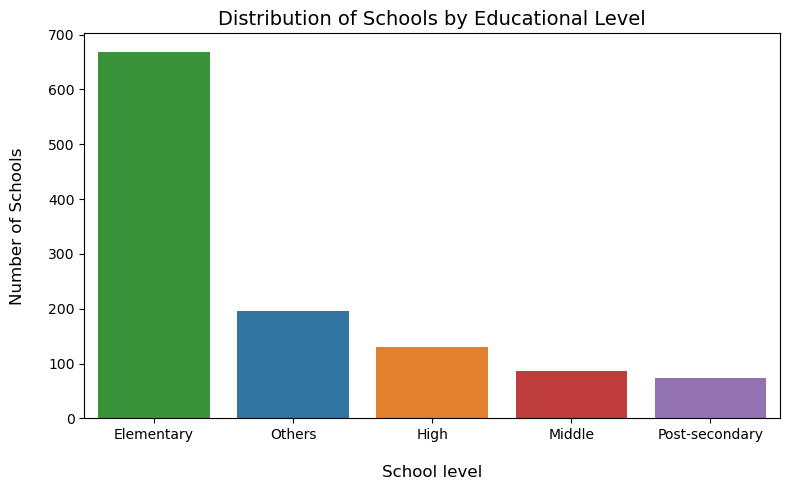

In [6]:
plt.figure(figsize=(8,5))

sns.countplot(
    x='SCHOOL_LEVEL',
    hue='SCHOOL_LEVEL',
    data=df_cleaned,
    order=df_cleaned['SCHOOL_LEVEL'].value_counts().index,
    palette='tab10',
    legend=False
)

plt.title('Distribution of Schools by Educational Level', fontsize=14)
plt.xlabel('\nSchool level', fontsize=12)
plt.ylabel('Number of Schools\n', fontsize=12)

plt.savefig('visuals/school_level_bar.png', bbox_inches='tight')
plt.xticks(rotation=0)
plt.tight_layout()

plt.show()

Bar charts reveal that elementary schools dominate Toronto’s educational landscape (~650 institutions), while middle and high schools are fewer. Post-secondary and specialized institutions form a small but diverse segment.

The “Others” category encompasses specialized institutions that fall outside standard classifications. These include art schools, technical colleges, adult education centers, and private schools that are not formally categorized by level. Including this group ensures a more complete view of Toronto’s diverse educational landscape.

**Note:** Some elementary schools extend to grades 7–8, overlapping with middle school classifications. This contributes to the low count of standalone middle schools and introduces classification complexity.

### School Level Pie Chart

A pie chart illustrates the relative proportions of school levels within the dataset, showcasing how each category—elementary, middle, secondary, post-secondary, and others—shapes the broader educational landscape of Toronto.

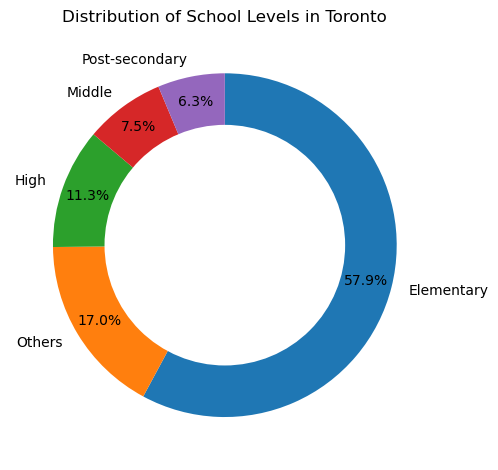

In [7]:
df_cleaned['SCHOOL_LEVEL'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False,
    pctdistance=0.85,
    )

plt.title("Distribution of School Levels in Toronto")
plt.ylabel('')
plt.gca().set_aspect('equal')

centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.savefig('visuals/school_level_pie.png', bbox_inches='tight')
plt.tight_layout()
plt.show()

### School Board Distribution

A bar chart illustrates the number of schools overseen by each educational board in Toronto, including public, Catholic, private, and Francophone institutions. This visualization provides insight into how governance is structured across the city’s school system.

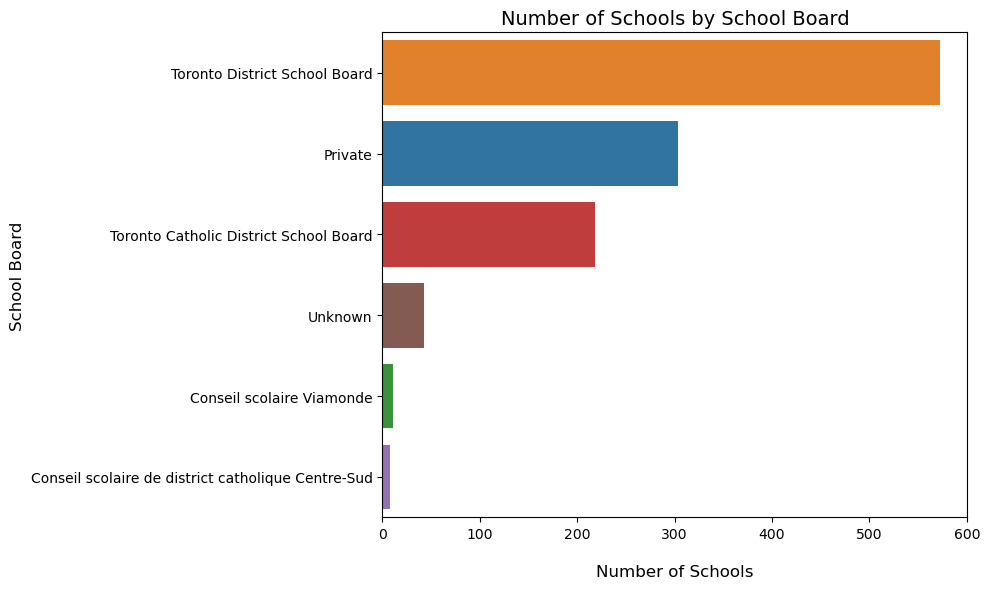

In [8]:
plt.figure(figsize=(10,6))
sns.countplot(
    y='BOARD_NAME',
    hue='BOARD_NAME',
    data=df_cleaned,
    order=df_cleaned['BOARD_NAME'].value_counts().index,
    palette='tab10',
    legend=False
)

plt.title('Number of Schools by School Board', fontsize=14)
plt.xlabel('\nNumber of Schools', fontsize=12)
plt.ylabel('School Board', fontsize=12)
plt.savefig('visuals/school_board_bar.png', bbox_inches='tight')

plt.tight_layout()
plt.show()

**Analysis:** The Toronto District School Board (TDSB) accounts for the largest share of schools, followed by private institutions and the Toronto Catholic District School Board. Francophone boards and entries with unspecified governance represent a smaller portion of the dataset. This distribution highlights the dominant role of public education providers, while also reflecting the diversity of administrative models within Toronto’s educational landscape.

### Stacked Bar Chart: Education Level by Board

A stacked bar chart is used to visualize how different education levels—elementary, middle, high, post-secondary, and other—are distributed across Toronto’s school boards. This visualization helps identify patterns of specialization and the relative focus of each board within the education system.

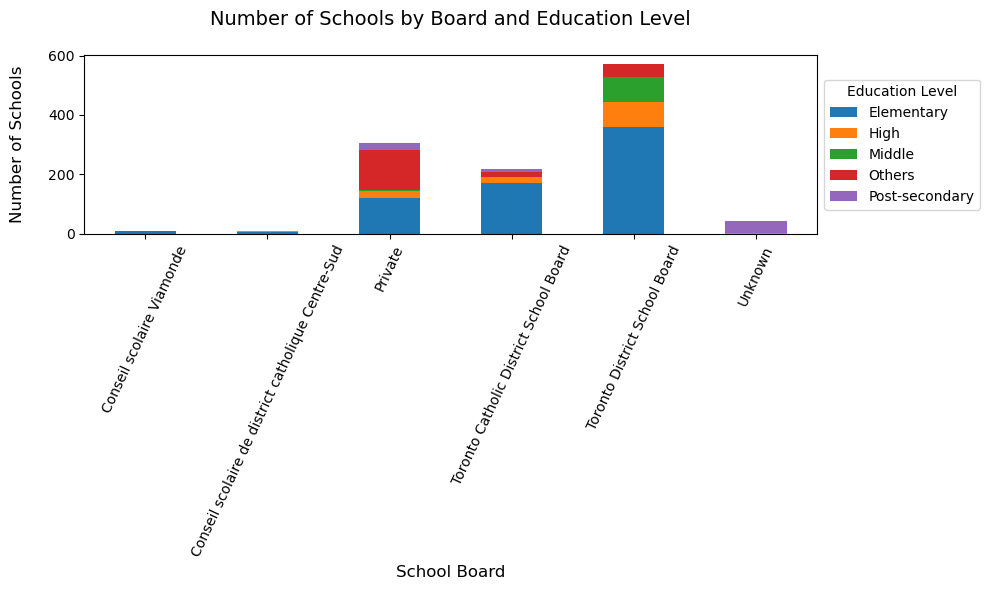

In [9]:
cross_tab = pd.crosstab(df_cleaned['BOARD_NAME'], df_cleaned['SCHOOL_LEVEL'])

ax = cross_tab.plot(
    kind='bar',
    stacked=True,
    figsize=(10,6)
)

plt.legend(
    title='Education Level',
    loc='center left',
    bbox_to_anchor=(1.0, 0.5)
)

plt.title('Number of Schools by Board and Education Level\n', fontsize=14)
plt.xlabel('School Board', fontsize=12)
plt.ylabel('Number of Schools\n', fontsize=12)
plt.xticks(rotation=65)
plt.savefig('visuals/level_and_board_bar.png', bbox_inches='tight')
plt.tight_layout()
plt.show()

**Analysis:**
The chart reveals that the Toronto District School Board (TDSB) and the Toronto Catholic District School Board manage the majority of elementary and secondary schools, reflecting their central role in public education. Private institutions demonstrate a broader presence across all levels, including post-secondary, indicating a more diversified educational offering. Francophone boards appear with fewer schools overall, suggesting a more localized or niche governance model.

This visualization not only highlights the number of institutions each board oversees but also provides insight into their strategic emphasis across different stages of education.

### Heatmap: Education Level by School Board

To deepen the analysis of governance patterns, a heatmap is used to visualize the distribution of schools by education level across Toronto’s school boards. This technique reveals structural trends that may not be immediately evident in raw tables, offering a clearer view of where specific types of institutions are concentrated.

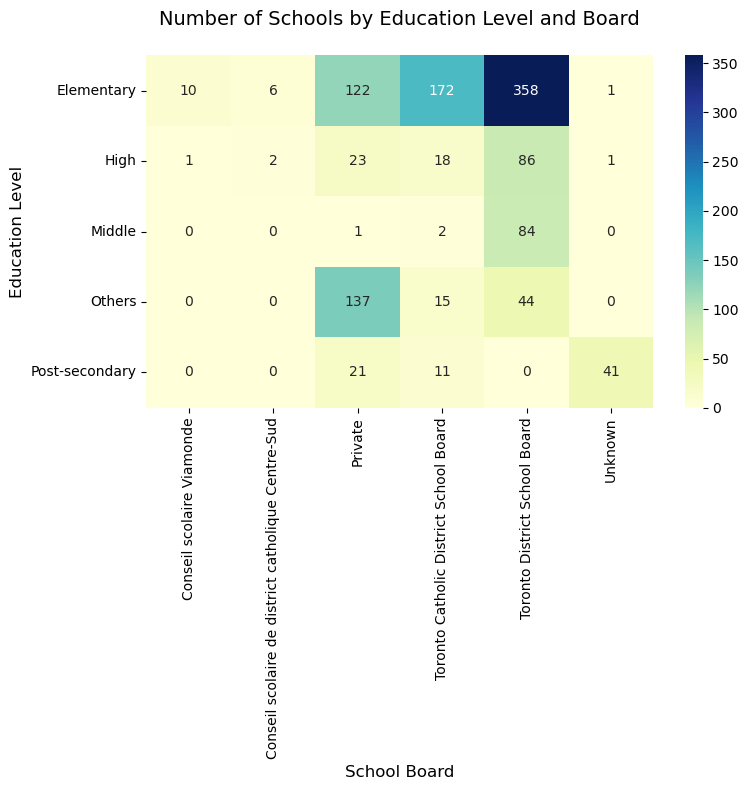

In [10]:
cross_tab2 = pd.crosstab(df_cleaned['SCHOOL_LEVEL'], df_cleaned['BOARD_NAME'])

plt.figure(figsize=(8,8))

sns.heatmap(
    cross_tab2,
    annot=True,
    fmt='d',
    cmap='YlGnBu'
)

plt.title('Number of Schools by Education Level and Board\n', fontsize=14)
plt.xlabel('School Board', fontsize=12)
plt.ylabel('Education Level', fontsize=12)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.savefig('visuals/level_and_board_heat.png', bbox_inches='tight')
plt.tight_layout()
plt.show()

**Analysis:** The heatmap shows how different school boards focus on various education levels. Some boards mainly manage elementary schools, while others are more involved in secondary or post-secondary education. Darker colors highlight the most common combinations, making it easier to spot patterns and compare board responsibilities. This chart builds on earlier tables and helps visualize how school governance is spread across Toronto.

### Distribution by City District

This chart shows how schools are distributed across Toronto city districts. It helps identify geographic concentration and potential service gaps.

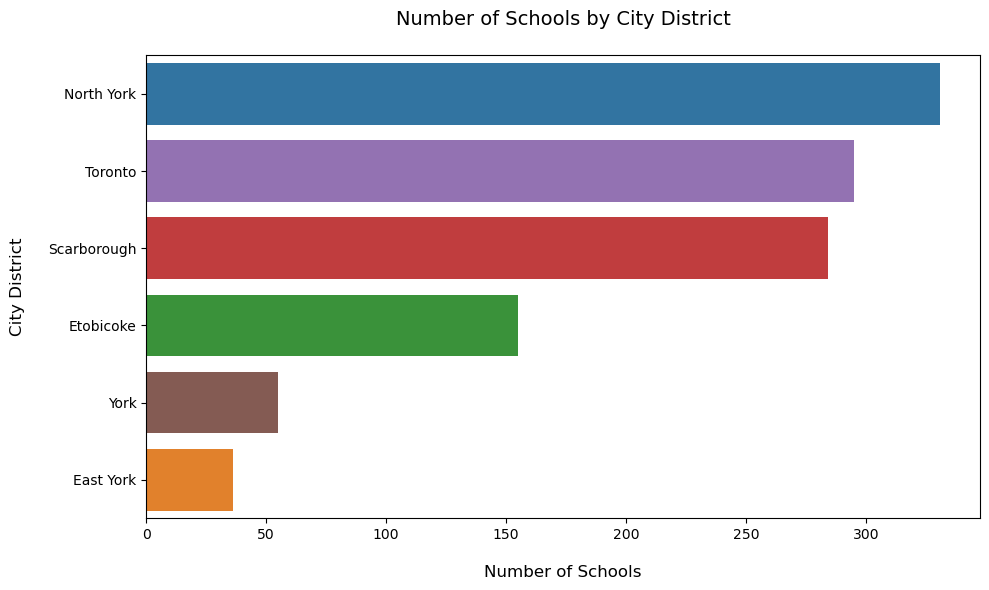

In [11]:
city_mapping = {
    'NY': 'North York',
    'SC': 'Scarborough',
    'ET': 'Etobicoke',
    'TO': 'Toronto',
    'EY': 'East York',
    'YK': 'York'
}

df_cleaned['CITY'] = df_cleaned['CITY'].replace(city_mapping)

plt.figure(figsize=(10,6))
sns.countplot(
    y='CITY',
    hue='CITY',
    data=df_cleaned,
    order=df_cleaned['CITY'].value_counts().index,
    palette='tab10',
    legend=False
)

plt.title("Number of Schools by City District\n", fontsize=14)
plt.xlabel("\nNumber of Schools", fontsize=12)
plt.ylabel("City District\n", fontsize=12)
plt.savefig('visuals/city_district_bar.png', bbox_inches='tight')
plt.tight_layout()
plt.show()

**Analysis:** North York and Scarborough have the largest number of schools, which corresponds with their expansive geographic size. Toronto (Central) also shows a high count due to its dense urban environment. In contrast, East York and York contain fewer schools, reflecting their smaller land area. While the distribution may appear uneven at first glance, it generally aligns with the physical size and population density of each district.

### School Type Distribution

This pie chart displays the breakdown of school types across Toronto, with slight emphasis on smaller categories to improve visibility. It helps illustrate the overall composition of the city’s educational system.

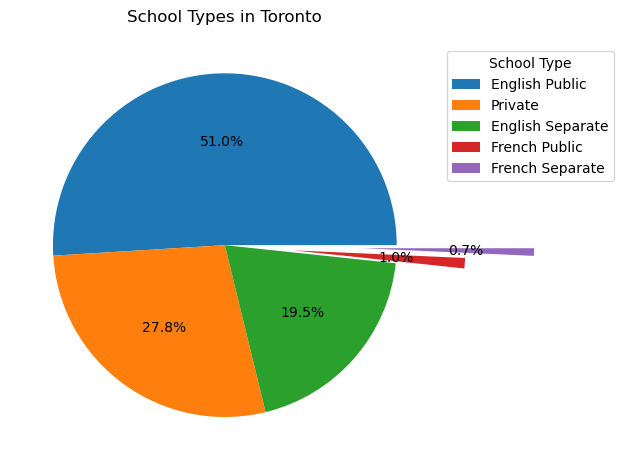

In [12]:
type_counts = df['SCHOOL_TYPE_DESC'].value_counts()
labels = type_counts.index

type_counts.plot(
    kind='pie',
    autopct='%1.1f%%',
    labels=None,
    explode=[0, 0, 0, 0.4, 0.8]
)

plt.title("School Types in Toronto")
plt.ylabel('')  # hide y-axis label
plt.legend(labels, title='School Type', loc='center left', bbox_to_anchor=(1.0, 0.8))

plt.tight_layout()
plt.savefig('visuals/school_type_pie.png', bbox_inches='tight')
plt.show()

**Analysis:** English Public schools make up the largest share of institutions (51%), followed by Private schools (27.8%) and English Separate schools (19.5%). French-language schools—both Public and Separate—account for less than 2% of the total. These proportions suggest that Toronto’s education system is primarily English and publicly governed, while still offering diversity through private and faith-based options.

## Visualizing School Locations in Toronto

This section explores the spatial distribution of schools across Toronto using two complementary visualization techniques:

- **Static Mapping** with Matplotlib and GeoPandas
- **Interactive Mapping** with Folium


### Static Map with GeoPandas and Matplotlib

A basic geographic plot displays the locations of schools across Toronto based on their coordinates. This initial visualization provides a broad overview of how schools are spread throughout the city.

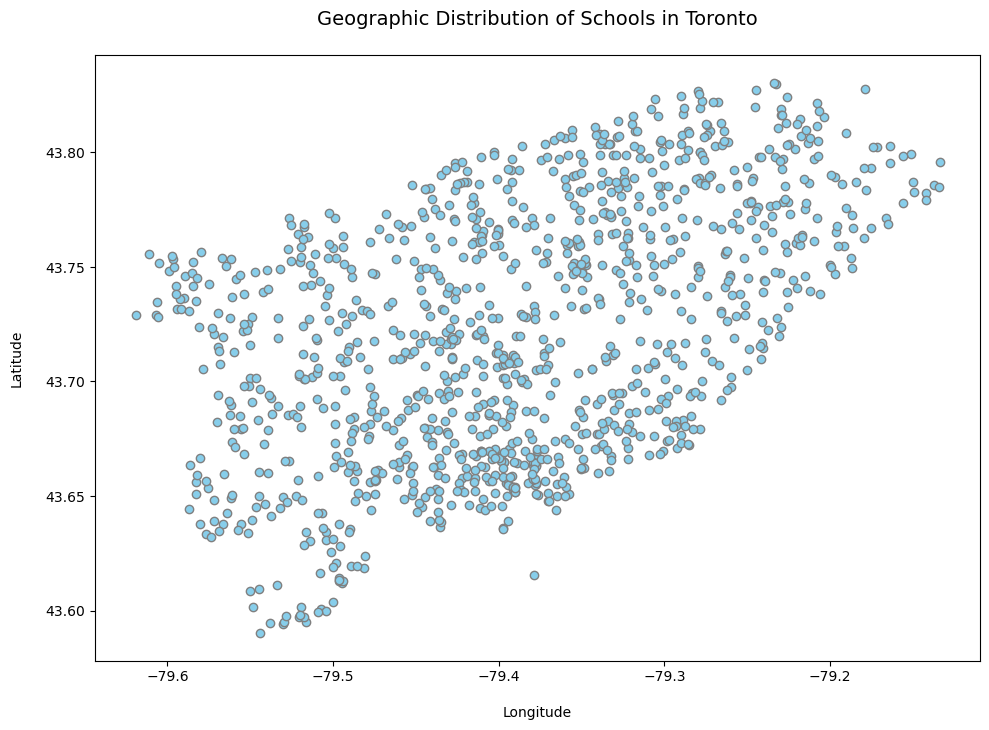

In [13]:
# Parse geometry string into dictionary
df_cleaned['geometry'] = df_cleaned['geometry'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# Extract coordinates
df_cleaned['Longitude'] = df_cleaned['geometry'].apply(lambda g: g['coordinates'][0][0])
df_cleaned['Latitude'] = df_cleaned['geometry'].apply(lambda g: g['coordinates'][0][1])

# Create shapely Point geometry
df_cleaned['geometry_point'] = df_cleaned.apply(
    lambda row: Point(row['Longitude'], row['Latitude']), axis=1
)

# Convert to GeoDataFrame with proper CRS
gdf = gpd.GeoDataFrame(df_cleaned, geometry='geometry_point', crs='EPSG:4326')

# Plot map
ax = gdf.plot(figsize=(10,8), color='skyblue', edgecolor='grey')
ax.set_title('Geographic Distribution of Schools in Toronto\n', fontsize=14)
ax.set_xlabel('\nLongitude')
ax.set_ylabel('Latitude\n')
plt.savefig("visuals/toronto_schools_map.png", dpi=100)
plt.tight_layout()
plt.show()

**Analysis:** At first glance, the distribution appears uneven—some areas show clear clustering, while others are noticeably sparse. While this map offers a general sense of accessibility, it lacks neighborhood-level precision and interactivity.

### Interactive School Map with Folium
To enhance spatial analysis, an interactive map was built using the Folium library. Each school is represented by a marker, and in densely populated areas, markers are grouped into clusters for clarity and usability.

This approach allows users to zoom in, explore specific neighborhoods, and interact with individual school data points—making it ideal for urban planning and community-level insights.

In [14]:
# Initialize the map centered over Toronto
m = folium.Map(location=[43.7, -79.4], zoom_start=11)

# Create a marker cluster to group nearby schools
marker_cluster = MarkerCluster().add_to(m)

# Add a marker for each school
for _, row in df_cleaned.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],  # Extracted coordinates
        tooltip=row['NAME'],                           # Tooltip shown on hover
        popup=f"<b>{row['NAME']}</b><br>Level: {row['SCHOOL_LEVEL']}<br>Type: {row['BOARD_NAME']}"  # Info shown on click
    ).add_to(marker_cluster)

# Display and save the map
m.save('visuals/toronto_schools_interactive_map.html')
m

### School Density Heatmap Using Folium
A heatmap was generated to visualize school density across Toronto. Unlike standard marker maps, the heatmap uses color intensity to highlight areas with high concentrations of schools.

In [15]:
# Prepare coordinate data for heatmap
heat_data = [[row['Latitude'], row['Longitude']] for _, row in df_cleaned.iterrows()]

# Initialize map centered on Toronto
m = folium.Map(location=[43.7, -79.4], zoom_start=11)

# Add heatmap layer
HeatMap(heat_data, radius=12, blur=18, max_zoom=1).add_to(m)

# Display and save map
m.save('visuals/toronto_schools_heatmap.html')
m

### Analysis of the School Density Map in Toronto
This heatmap illustrates the spatial distribution of schools across Toronto using color gradients to represent density. Areas with a high concentration of schools are shown in green and yellow, while regions with fewer schools appear in blue and purple. 

__1. Spatial Distribution__
- Central Toronto neighborhoods—especially Midtown, the University district, and parts of Downtown—show a high concentration of educational institutions. This reflects historical urban development, dense housing, and strong demand for schooling.
- Peripheral areas such as Scarborough, Etobicoke, and North York exhibit lower school density, likely due to lower population density, larger residential plots, and fewer multi-unit dwellings.

__2. Transportation Accessibility__
- High school density near subway lines and major transit corridors (e.g., Yonge Street, Bloor Street) suggests a strong correlation between transit access and school placement.
- Areas with limited public transit options tend to have fewer schools, which may pose accessibility challenges for students, particularly those from low-income households.

__3. Socio-Economic Context__
- Neighborhoods with higher socio-economic status (e.g., Rosedale, Forest Hill) host a significant number of private schools.
- Ethnically diverse and lower-income communities (e.g., Flemingdon Park, Jane-Finch) often exhibit lower school density despite greater educational need, indicating a possible mismatch between infrastructure and community demand.

__4. Urban Planning & Development__
- The map serves as a practical tool for city planners, helping identify areas where new schools or expansions may be needed.
- It also offers insight into educational equity by highlighting whether students across different districts have equal access to learning opportunities.

### Conclusions
- Central Toronto has the highest school density, closely tied to population concentration, transit infrastructure, and historical development.

- Some outer districts may require additional support, especially those with shifting demographics and growing educational needs.

- Combining spatial data with demographic, socio-economic, and transit indicators can offer a deeper understanding of educational accessibility and help guide future planning decisions.